In [62]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 30)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


In [63]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-26,206.490005,26043600.0,1.031529,0.306036
2019-08-27,204.160004,25873300.0,2.458858,-1.780043
2019-08-28,205.529999,15938800.0,1.167710,0.700633
2019-08-29,209.009995,20990500.0,1.272668,0.244602
2019-08-30,208.740005,21143400.0,1.556961,-0.675675


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style



In [64]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
print('el forecast out', forecast_out)
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# print('el array', X)
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_forecast = X[-forecast_out:] # set X_forecast equal to last 30
X = X[:-forecast_out]


y = np.array(dfreg['label'])
y = y[:-forecast_out]


el forecast out 25


In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)


In [66]:

# Linear regression
clfreg = LinearRegression()
clfreg.fit(x_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(x_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(x_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(x_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [67]:
confidencereg = clfreg.score(x_test, y_test)
confidencepoly2 = clfpoly2.score(x_test,y_test)
confidencepoly3 = clfpoly3.score(x_test,y_test)
confidenceknn = clfknn.score(x_test, y_test)
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.8884778908845931
The quadratic regression 2 confidence is  0.9044270689160371
The quadratic regression 3 confidence is  0.9295448369078014
The knn regression confidence is  0.9389071441215203


In [68]:
forecast_set = clfknn.predict(X_forecast)
dfreg['Forecast'] = np.nan
print('forecast', forecast_set)

forecast [211.58972168 215.49599457 183.55545807 191.75788879 185.6396637
 156.64237213 200.87677765 159.41413116 182.32725525 208.36417389
 215.49991608 178.78630829 186.29717255 192.14392853 188.28309631
 218.43045044 215.67324829 219.41023254 215.21042633 176.01020813
 218.54862976 200.46842957 207.60500336 215.51527405 189.52500916]


last data 2019-08-30 00:00:00


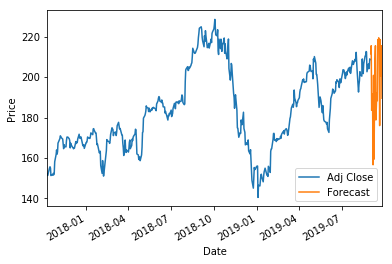

In [69]:
last_date = dfreg.iloc[-1].name
print('last data', last_date)
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()